In [3]:
import os
from scipy.io import loadmat
import h5py

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load mat file data
mat = h5py.File(os.path.join("NYUv2", "nyu_depth_v2_labeled.mat"), 'r', libver='latest', swmr=True)

# Images are in 4D array (1449, 3, 640, 480), and depth maps are in 3D array (1449, 640, 480).
# We can simply transpose the axes to get them in a format suitable for training.

images = np.transpose(mat["images"], (0, 2, 3, 1))
depths = np.transpose(mat["depths"], (0, 2, 1))

# Shuffle data
indices = np.arange(images.shape[0])
np.random.shuffle(indices)
images = images[indices]
depths = depths[indices]

# Split data into training and validation
train_images = images[:1000]
train_depths = depths[:1000]
val_images = images[1000:]
val_depths = depths[1000:]

train_depths = np.transpose(train_depths, (0, 2, 1))
val_depths = np.transpose(val_depths, (0, 2, 1))

In [4]:
def crop_images(images, percentage):
    # The percentage should be between 0 and 1
    height, width = images.shape[1], images.shape[2]
    start_row = int(height * percentage / 2)
    end_row = height - start_row
    start_col = int(width * percentage / 2)
    end_col = width - start_col
    return images[:, start_row:end_row, start_col:end_col, :]

percentage = 0.30  

# Crop training images
train_images = crop_images(train_images, percentage)
val_images = crop_images(val_images, percentage)


In [5]:
print(train_images[0].shape)

(448, 336, 3)


In [6]:
# Extract depth value at the center
center_depths_train = train_depths[:, 320, 240]
center_depths_val = val_depths[:, 320, 240]

# normalize images for better network performance
train_images = train_images / 255.
val_images = val_images / 255.

# Reshape depths for suitable training 
center_depths_train = center_depths_train.reshape(-1, 1)
center_depths_val = center_depths_val.reshape(-1, 1)

In [3]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

def create_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(320, 120, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))

    return model


In [5]:
from tensorflow.keras.applications import VGG16

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras import regularizers

def create_model():
    # Load the VGG16 network, ensuring the head FC layer sets are left off
    vgg = VGG16(weights="imagenet", include_top=False, input_shape=(448, 336, 3))

    # Freeze all layers in the VGG16 so that they will not be updated during the first training process
    vgg.trainable = False

    model = Sequential()
    # Add the VGG16 model
    model.add(vgg)
    model.add(Flatten())
    model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.1)))
    model.add(Dense(1))

    return model

### Huber Loss

In [6]:
from tensorflow.keras.losses import Huber

optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.0002,
    amsgrad=False,
)

model = create_model()

model.compile(optimizer, loss=Huber())

history = model.fit(train_images, center_depths_train, epochs=20, 
                    validation_data=(val_images, center_depths_val), batch_size=32)

Epoch 1/20
32/32 [==============================] - 15s 264ms/step - loss: 8.2494 - val_loss: 4.0118
Epoch 2/20
32/32 [==============================] - 6s 174ms/step - loss: 2.7899 - val_loss: 2.0573
Epoch 3/20
32/32 [==============================] - 6s 178ms/step - loss: 1.6359 - val_loss: 1.4485
Epoch 4/20
32/32 [==============================] - 6s 174ms/step - loss: 1.1165 - val_loss: 1.1165
Epoch 5/20
32/32 [==============================] - 6s 175ms/step - loss: 0.8284 - val_loss: 0.9310
Epoch 6/20
32/32 [==============================] - 6s 176ms/step - loss: 0.6612 - val_loss: 0.8462
Epoch 7/20
32/32 [==============================] - 6s 176ms/step - loss: 0.5211 - val_loss: 0.6945
Epoch 8/20
32/32 [==============================] - 6s 178ms/step - loss: 0.4287 - val_loss: 0.6601
Epoch 9/20
32/32 [==============================] - 6s 179ms/step - loss: 0.3891 - val_loss: 0.6118
Epoch 10/20
32/32 [==============================] - 6s 178ms/step - loss: 0.3268 - val_loss: 0.548

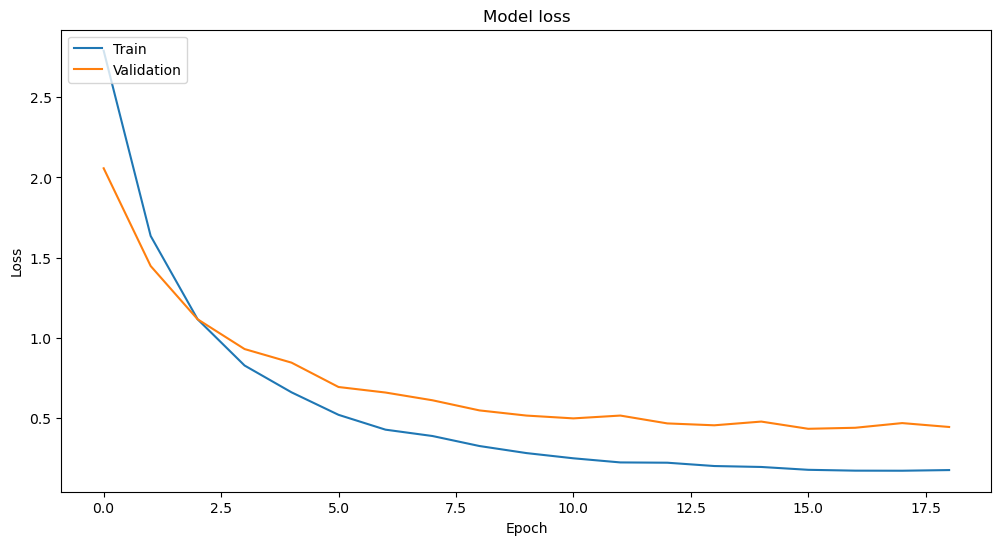

In [7]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][1:])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [8]:
# Making predictions
predictions = model.predict(val_images[0:10])

# Compare the first 10 predicted distances with actual distances
for i in range(10):
    print(f"Predicted distance: {predictions[i][0]}, Actual distance: {center_depths_val[i][0]}")

1/1 [==============================] - 2s 2s/step
Predicted distance: 2.472062826156616, Actual distance: 2.692040205001831
Predicted distance: 3.691336154937744, Actual distance: 2.1228270530700684
Predicted distance: 2.54803466796875, Actual distance: 1.0110801458358765
Predicted distance: 2.4275076389312744, Actual distance: 2.364774703979492
Predicted distance: 2.92364501953125, Actual distance: 1.5843454599380493
Predicted distance: 2.1408884525299072, Actual distance: 1.7518556118011475
Predicted distance: 2.4427621364593506, Actual distance: 2.06807804107666
Predicted distance: 1.6791480779647827, Actual distance: 1.298647403717041
Predicted distance: 2.5469720363616943, Actual distance: 1.1353209018707275
Predicted distance: 2.7378170490264893, Actual distance: 3.483288526535034


In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Predicting the distances on the validation set
val_predictions = model.predict(val_images)

# Reshaping predictions and true values to one-dimensional arrays
val_predictions = val_predictions.reshape(-1)
true_values = center_depths_val.reshape(-1)

# Calculate Mean Absolute Error
mae = mean_absolute_error(true_values, val_predictions)
print(f"Mean Absolute Error (MAE): {mae} meters")

# Calculate Mean Squared Error
mse = mean_squared_error(true_values, val_predictions)
print(f"Mean Squared Error (MSE): {mse} meters")


15/15 [==============================] - 2s 135ms/step
Mean Absolute Error (MAE): 0.69199538230896 meters
Mean Squared Error (MSE): 0.7412119507789612 meters


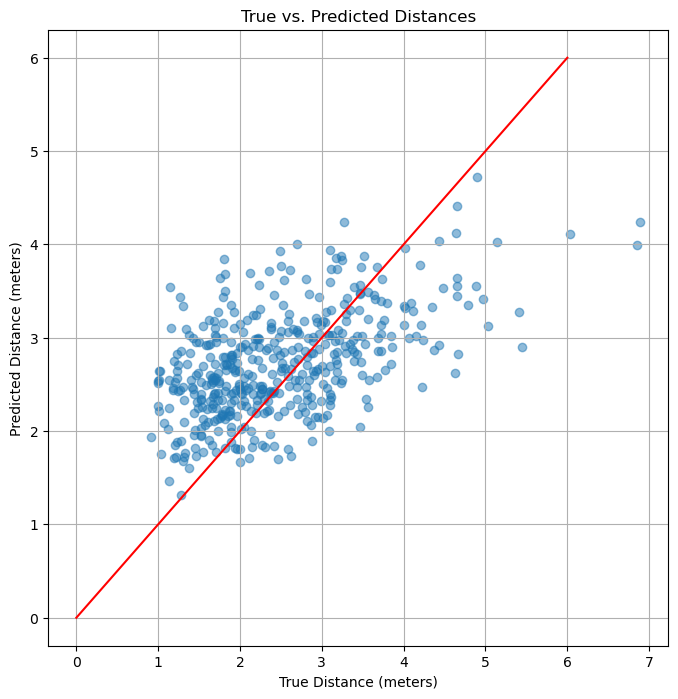

In [11]:
import matplotlib.pyplot as plt

# Scatter plot of true vs. predicted distances
plt.figure(figsize=(8, 8))
plt.scatter(true_values, val_predictions, alpha=0.5)
plt.plot([0, 6], [0, 6], color='red')  # Ideal model would follow this line
plt.xlabel('True Distance (meters)')
plt.ylabel('Predicted Distance (meters)')
plt.title('True vs. Predicted Distances')
plt.grid(True)
plt.show()


### MSE

In [6]:
from tensorflow.keras.losses import Huber

optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.0002,
    amsgrad=False,
)

model = create_model()

model.compile(optimizer, loss='mean_squared_error')

history = model.fit(train_images, center_depths_train, epochs=50, 
                    validation_data=(val_images, center_depths_val), batch_size=32)

Epoch 1/50
32/32 [==============================] - 15s 269ms/step - loss: 12.3377 - val_loss: 7.9661
Epoch 2/50
32/32 [==============================] - 6s 178ms/step - loss: 6.6153 - val_loss: 5.8593
Epoch 3/50
32/32 [==============================] - 6s 177ms/step - loss: 4.7854 - val_loss: 4.8328
Epoch 4/50
32/32 [==============================] - 6s 178ms/step - loss: 3.7527 - val_loss: 4.1769
Epoch 5/50
32/32 [==============================] - 6s 177ms/step - loss: 3.0887 - val_loss: 3.7086
Epoch 6/50
32/32 [==============================] - 6s 176ms/step - loss: 2.6225 - val_loss: 3.3639
Epoch 7/50
32/32 [==============================] - 6s 181ms/step - loss: 2.1807 - val_loss: 3.1005
Epoch 8/50
32/32 [==============================] - 6s 176ms/step - loss: 1.8694 - val_loss: 2.8483
Epoch 9/50
32/32 [==============================] - 6s 179ms/step - loss: 1.6235 - val_loss: 2.6913
Epoch 10/50
32/32 [==============================] - 6s 176ms/step - loss: 1.4358 - val_loss: 2.70

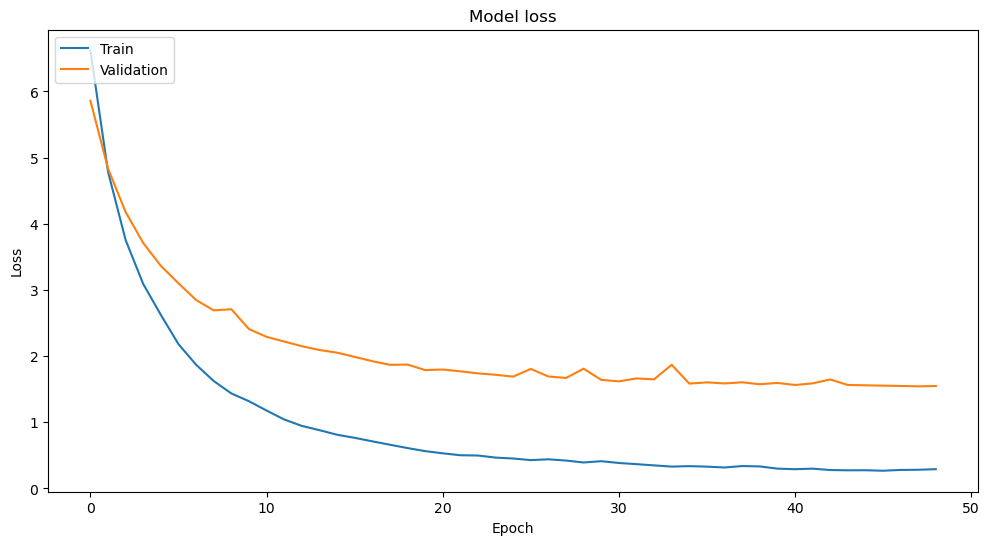

In [7]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][1:])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [8]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Predicting the distances on the validation set
val_predictions = model.predict(val_images)

# Reshaping predictions and true values to one-dimensional arrays
val_predictions = val_predictions.reshape(-1)
true_values = center_depths_val.reshape(-1)

# Calculate Mean Absolute Error
mae = mean_absolute_error(true_values, val_predictions)
print(f"Mean Absolute Error (MAE): {mae} meters")

# Calculate Mean Squared Error
mse = mean_squared_error(true_values, val_predictions)
print(f"Mean Squared Error (MSE): {mse} meters")


15/15 [==============================] - 2s 116ms/step
Mean Absolute Error (MAE): 0.8061769604682922 meters
Mean Squared Error (MSE): 1.3522870540618896 meters


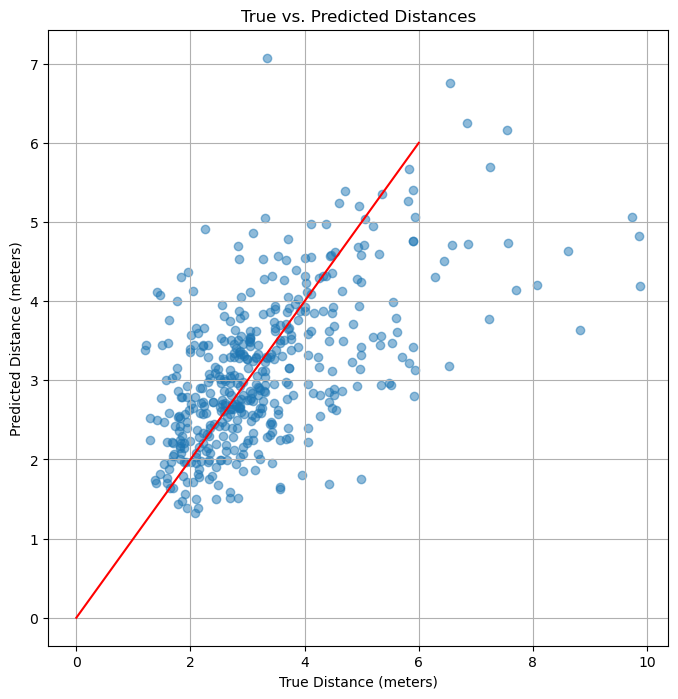

In [9]:
import matplotlib.pyplot as plt

# Scatter plot of true vs. predicted distances
plt.figure(figsize=(8, 8))
plt.scatter(true_values, val_predictions, alpha=0.5)
plt.plot([0, 6], [0, 6], color='red')  # Ideal model would follow this line
plt.xlabel('True Distance (meters)')
plt.ylabel('Predicted Distance (meters)')
plt.title('True vs. Predicted Distances')
plt.grid(True)
plt.show()


In [11]:
model.save('distance_prediction.h5')

In [7]:
import tensorflow as tf

model = tf.keras.models.load_model('distance_prediction.h5')

In [8]:
#Fine-Tuning
from tensorflow.keras.optimizers import Adam

# Unfreeze the last few layers
for layer in model.layers[0].layers[-1:]:
    layer.trainable = True

# Recompile the model for the changes to take effect
# We use a lower learning rate for fine-tuning
model.compile(optimizer=Adam(lr=1e-5), loss='mean_squared_error')

# Retrain the model
history = model.fit(train_images, center_depths_train, epochs=5, 
                    validation_data=(val_images, center_depths_val), batch_size=32)


C:\Anaconda\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/5
32/32 [==============================] - 15s 269ms/step - loss: 0.6274 - val_loss: 0.6810
Epoch 2/5
32/32 [==============================] - 6s 177ms/step - loss: 0.5739 - val_loss: 0.6725
Epoch 3/5
32/32 [==============================] - 6s 178ms/step - loss: 0.5362 - val_loss: 0.6680
Epoch 4/5
32/32 [==============================] - 6s 178ms/step - loss: 0.5083 - val_loss: 0.6670
Epoch 5/5
32/32 [==============================] - 6s 177ms/step - loss: 0.4840 - val_loss: 0.6653


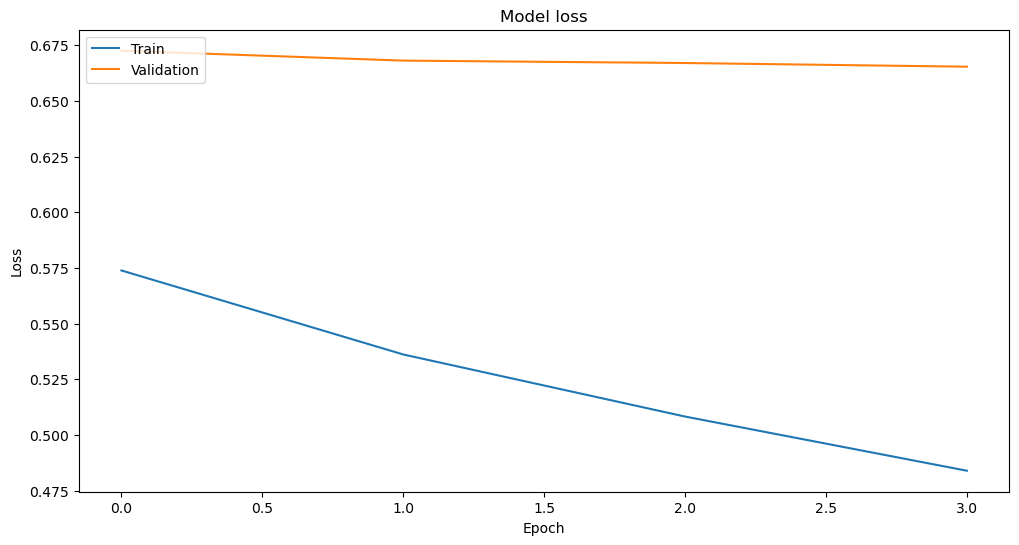

In [9]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][1:])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Predicting the distances on the validation set
val_predictions = model.predict(val_images)

# Reshaping predictions and true values to one-dimensional arrays
val_predictions = val_predictions.reshape(-1)
true_values = center_depths_val.reshape(-1)

# Calculate Mean Absolute Error
mae = mean_absolute_error(true_values, val_predictions)
print(f"Mean Absolute Error (MAE): {mae} meters")

# Calculate Mean Squared Error
mse = mean_squared_error(true_values, val_predictions)
print(f"Mean Squared Error (MSE): {mse} meters")

15/15 [==============================] - 2s 115ms/step
Mean Absolute Error (MAE): 0.35966452956199646 meters
Mean Squared Error (MSE): 0.48929092288017273 meters


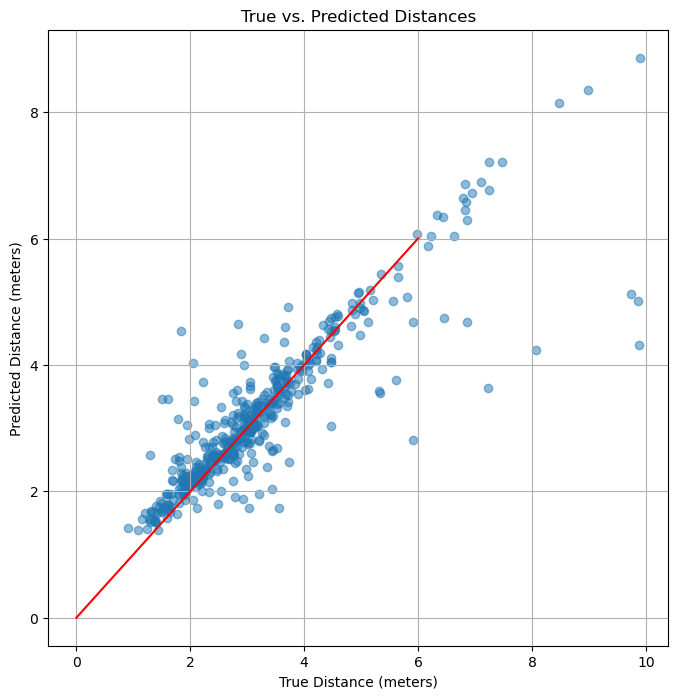

In [11]:
import matplotlib.pyplot as plt

# Scatter plot of true vs. predicted distances
plt.figure(figsize=(8, 8))
plt.scatter(true_values, val_predictions, alpha=0.5)
plt.plot([0, 6], [0, 6], color='red')  # Ideal model would follow this line
plt.xlabel('True Distance (meters)')
plt.ylabel('Predicted Distance (meters)')
plt.title('True vs. Predicted Distances')
plt.grid(True)
plt.show()

In [10]:
# Making predictions
predictions = model.predict(val_images[0:10])

# Compare the first 10 predicted distances with actual distances
for i in range(10):
    print(f"Predicted distance: {predictions[i][0]}, Actual distance: {center_depths_val[i][0]}")


1/1 [==============================] - 2s 2s/step
Predicted distance: 1.552003026008606, Actual distance: 1.5697094202041626
Predicted distance: 3.3757519721984863, Actual distance: 3.372344970703125
Predicted distance: 3.6845831871032715, Actual distance: 3.4473721981048584
Predicted distance: 3.9991652965545654, Actual distance: 4.270726203918457
Predicted distance: 1.7932473421096802, Actual distance: 1.6373255252838135
Predicted distance: 1.6868045330047607, Actual distance: 1.6846277713775635
Predicted distance: 2.3585317134857178, Actual distance: 2.230548858642578
Predicted distance: 2.386525869369507, Actual distance: 2.1603598594665527
Predicted distance: 2.8380825519561768, Actual distance: 2.8236887454986572
Predicted distance: 3.0411598682403564, Actual distance: 3.1798768043518066


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 18ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 18ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 18ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 26ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 16ms/step


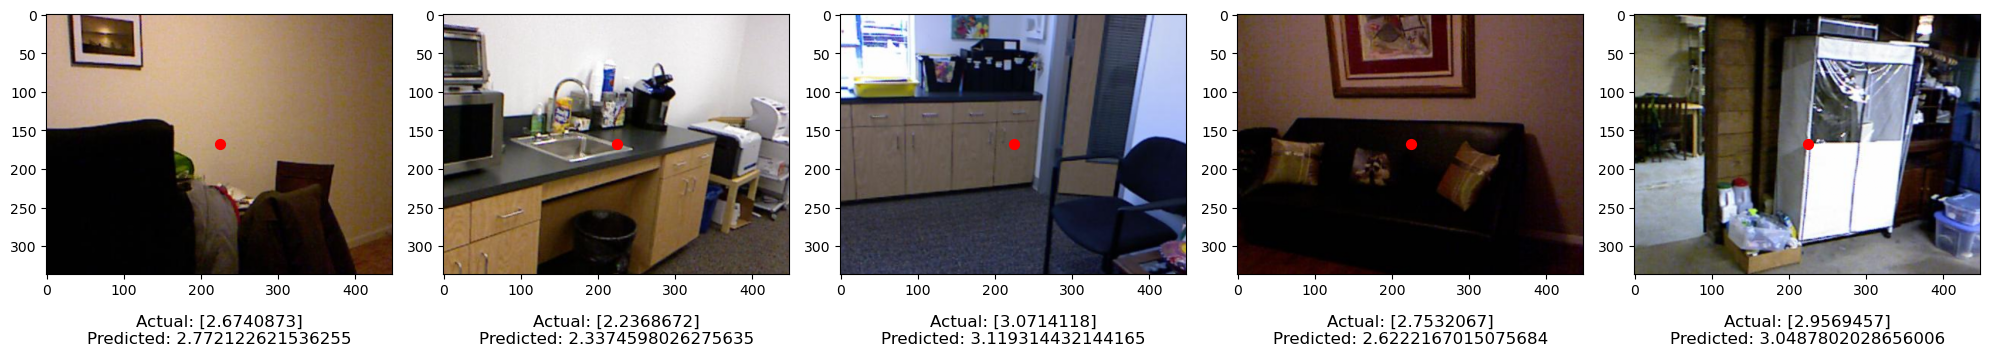

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage

def display_images_with_distance(model, images, actual_distances=None, rotation_angle=90):
    plt.figure(figsize=(20, 20))  # increased figure size
    for i in range(5):
        ax = plt.subplot(1, 5, i + 1)
        
        # rotate and display image
        rotated_image = ndimage.rotate(images[i], angle=270)
        plt.imshow(rotated_image)
        
        # mark the center of the image
        plt.scatter([rotated_image.shape[1] // 2], [rotated_image.shape[0] // 2], s=50, c='red')
        
        # predict distance
        img_array = np.expand_dims(images[i], axis=0)  # we do not rotate the image for prediction
        predicted_distance = model.predict(img_array)[0][0]

        if actual_distances is not None:
            title = f"Actual: {actual_distances[i]}\nPredicted: {predicted_distance}"
        else:
            title = f"Predicted: {predicted_distance:.2f}"
            
        # move the title higher to prevent overlapping
        plt.title(title, y=-0.30)
        
    plt.tight_layout()
    plt.show()

test_images = val_images 
actual_distances = center_depths_val  
display_images_with_distance(model, test_images, actual_distances)


In [13]:
model.save('distance_prediction_fine_tuned.h5')